# 导入必须的模块

# 步骤1-1 模块导入

In [1]:
print("导入模块")
!pip install pycocotools # 安装pycocotools模块，处理数据集
# !pip uninstall torchvision
# !pip install -U torchvision==0.8.2
import os # 导入系统文件操作模块
import argparse # 导入读取参数的模块
import datetime # 导入操作时间日期的模块
import json # 导入操作json格式文件的模块
import random # 导入随机操作模块
import time # 导入操作时间的模块
from pathlib import Path # 导入操作路径的模块
import numpy as np # 导入操作数组的模块
import torch #导入深度学习pytorch模块
from torch.utils.data import DataLoader # 从torch中导入数据生成器和分布式取样模块
import datasets # 导入自定义的datasets模块
import util.misc as utils #从自定义的util.py文件中导入utils函数
from datasets import build_dataset, get_coco_api_from_dataset # 从自定义的datasets.py中导入构建数据集的函数
from models import build_model # 从models.py中导入构建模型的函数
from matplotlib import pyplot as plt # 导入绘制图像的plt函数
from PIL import Image # 导入读取和处理图像的Image函数
from train import * # 从自定义的train.py中导入所需函数
from predict import * # 从自定义的predict.py中导入所需函数
print("模块导入成功！")

导入模块
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


模块导入成功！


# 步骤2-1 参数设定

In [2]:
print("参数设定")
class config:
    lr = 1e-4 # 学习率
    lr_backbone = 1e-5 # backbone的学习率
    lr_drop = 50 # 学习率衰减
    batch_size = 1 # 批次大小
    weight_decay = 1e-4 # 权重衰减
    epochs = 1 # 训练回合数
    one_epoch_steps = 2 # 一个epoch中的迭代次数
    num_classes = 5 # 类别数
    dataset_file = "custom" # 使用自定义的数据库函数，不需要更改
    coco_path = r"MyDatasets" # 自定义数据集路径的路径
    device = "cpu" # 设定设备为cpu
    seed = 42 # 随机种子
    resume = "detr-r50_no-class-head.pth" # 'resume from checkpoint'
    num_workers = 1 # 读取数据的进程数
    output_dir = "outputs" # 保存模型的路径
    
args = get_args_parser(config()).parse_args([]) # 加载参数
if args.output_dir: # 建立输出文件夹
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
utils.init_distributed_mode(args) # 初始化分布式模型参数配置
device = torch.device(args.device) # 设定是cpu还是gpu环境
seed = args.seed + utils.get_rank() # 设定随机种子以便于复现
torch.manual_seed(seed) # 固定torch随机种子
np.random.seed(seed) # 固定numpy随机种子
random.seed(seed) # 固定random随机种子
output_dir = Path(args.output_dir) # 定义保存路径
print(args) # 打印参数配置信息
print("参数设定完成")

参数设定
Not using distributed mode
Namespace(aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='MyDatasets', dataset_file='custom', dec_layers=1, device='cpu', dice_loss_coef=1, dilation=False, dim_feedforward=64, dist_url='env://', distributed=False, dropout=0.1, enc_layers=1, eos_coef=0.1, epochs=1, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=4, lr=0.0001, lr_backbone=1e-05, lr_drop=50, mask_loss_coef=1, masks=False, nheads=4, num_classes=5, num_queries=100, num_workers=1, one_epoch_steps=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume=False, seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=3)
参数设定完成


# 步骤3-1 构建数据生成器

In [3]:
print("构建数据生成器")
dataset_train = build_dataset(image_set='train', args=args) # 构建训练集
dataset_val = build_dataset(image_set='val', args=args) # 构建验证集


# 采用随机取样分配每一batch的数据
sampler_train = torch.utils.data.RandomSampler(dataset_train) #分配每一训练batch的数据
sampler_val = torch.utils.data.SequentialSampler(dataset_val) #分配每一验证batch的数据
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)# 设置取样策略
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn, num_workers=args.num_workers)# 设置训练dataloader
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)# 设置测试dataloader
# 调用show_image函数展示部分图片数据
# show_image('MyDatasets/test/LZ122.jpg')
# show_image('MyDatasets/test/LT49.jpg')
# show_image('MyDatasets/test/hld011.jpg')
# show_image('MyDatasets/test/75.jpg')
print("构建完成")

构建数据生成器
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
构建完成


# 步骤3-2 构建模型及损失函数

In [5]:
print("构建模型及损失函数")
!cp /home/admin/jupyter/resnet50-19c8e357.pth /home/admin/.cache/torch/hub/checkpoints/
model, criterion, postprocessors = build_model(args) # 建立模型
model.to(device) # 将模型转移到指定设备上
print(model) # 打印模型结构
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad) # 获取并打印模型参数数量
print('参数量:', n_parameters)
print("建立完成")

构建模型及损失函数
DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=4, out_features=4, bias=True)
          )
          (mult

# 步骤3-3 构建优化器和学习率调整策略

In [6]:
# 给backbone和主网络分别配置优化器
print("构建优化器和学习率调整策略")
param_dicts = [
    {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},# 获取非骨干网络的参数
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],# 获取骨干网络的参数
        "lr": args.lr_backbone, # 获取骨干网络的学习率
    },
]
optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,weight_decay=args.weight_decay)# 定义优化器
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop) # 设置学习率调整策略
print("构建完成")

构建优化器和学习率调整策略
构建完成


# 步骤4-1 定义模型训练函数

In [7]:
print("定义模型训练函数")
# 训练一个epoch，输入参数依次为：模型网络、损失函数、训练数据生成器、优化器、回合数、权重剪枝策略、一个回合的迭代次数
def train_one_epoch(model, criterion,data_loader, optimizer,
                    device, epoch: int, max_norm = 0, one_epoch_steps = 2):
    model.train() # 将模型设定为训练模式
    step = 0 # 记录迭代次数
    for samples, targets in data_loader:
        start_time = time.time() # 记录一个迭代开始时间
        if step >= one_epoch_steps: # 如果达到迭代次数，结束该回合训练
            break
        optimizer.zero_grad() # 梯度清零
        samples = samples.to(device) # 将图片数据放到指定设备上
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # 将标签数据放到指定设备上
        outputs = model(samples) # 模型执行前向传播 
        loss_dict = criterion(outputs, targets) # 通过损失函数计算模型损失
        weight_dict = criterion.weight_dict # 获取损失函数结构
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict) # 将所有损失加起来
        losses.backward() # 根据损失进行反向传播求导
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm) # 对模型参数梯度进行剪枝，防止过拟合
        optimizer.step() # 使用优化器更新模型参数
        waste_time = time.time() - start_time # 计算训练损耗的时间
        print('step:' + str(step+1) + '/' + str(one_epoch_steps) + ' || Total Loss: %.4f || %.4fs/step' % (losses.item(), waste_time))
        step += 1 # 迭代次数记录+1
print("定义完成")

定义模型训练函数
定义完成


# 步骤4-2 模型训练

In [46]:
print("开始模型训练")
start_time = time.time() # 记录训练时间
for n, p in model.named_parameters():# 冻结骨干网络，加快模型训练
    if ("backbone" in n or "transformer" in n) and p.requires_grad:
        p.requires_grad = False
for epoch in range(args.start_epoch, args.epochs):
    print('\n' + '-' * 10 + 'Train one epoch.' + '-' * 10)
    print('Epoch:'+ str(epoch+1) + '/' + str(args.epochs))
    train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,args.clip_max_norm,args.one_epoch_steps) # 训练一个epoch
    lr_scheduler.step() # 学习率衰减
    if args.output_dir:
        checkpoint_path =  output_dir / 'checkpoint.pth' # 设定保存路径
        utils.save_on_master({
                'model': model.state_dict(), # 保存模型网络
                'optimizer': optimizer.state_dict(), # 保存优化器参数
                'lr_scheduler': lr_scheduler.state_dict(), # 保存学习率调整策略参数
                'epoch': epoch,# 保存训练回合数
                'args': args,# 保存配置参数
            }, checkpoint_path) 
total_time = time.time() - start_time # 计算训练总耗时
total_time_str = str(datetime.timedelta(seconds=int(total_time))) # 转换时间格式
print('Training time {}'.format(total_time_str)) # 显示耗时
print("训练完成")

开始模型训练

----------Train one epoch.----------
Epoch:1/1
step:1/2 || Total Loss: 7.4241 || 131.0978s/step
step:2/2 || Total Loss: 6.4587 || 88.7903s/step
Training time 0:03:42
训练完成


# 步骤4-3 模型微调

In [47]:
print("开始模型微调")
checkpoint = torch.load('outputs/checkpoint.pth',map_location='cpu')# 读取上次的模型权重
model.load_state_dict(checkpoint['model'],strict=False)# 加载上次的模型权重到该模型中
start_time = time.time() # 记录训练时间
for epoch in range(args.start_epoch, args.epochs):
    print('\n' + '-' * 10 + 'Train one epoch.' + '-' * 10)
    print('Epoch:'+ str(epoch+1) + '/' + str(args.epochs))
    # 训练一个epoch
    train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch,args.clip_max_norm,args.one_epoch_steps) 
    lr_scheduler.step() # 学习率衰减
    if args.output_dir:
        checkpoint_path =  output_dir / 'checkpoint.pth' # 设定保存路径
        utils.save_on_master({
                'model': model.state_dict(), # 保存模型网络
                'optimizer': optimizer.state_dict(),# 保存优化器参数
                'lr_scheduler': lr_scheduler.state_dict(), # 保存学习率调整策略参数
                'epoch': epoch,# 保存训练回合数
                'args': args, # 保存参数配置
            }, checkpoint_path) 
total_time = time.time() - start_time # 计算训练总耗时
total_time_str = str(datetime.timedelta(seconds=int(total_time))) # 转换时间格式
print('Training time {}'.format(total_time_str)) # 显示耗时
print("训练完成")

继续模型训练

----------Train one epoch.----------
Epoch:1/1
step:1/2 || Total Loss: 6.8743 || 137.1861s/step
step:2/2 || Total Loss: 6.8770 || 89.2881s/step
Training time 0:03:48
训练完成


# 步骤5-1 加载预测模型及定义预测函数

In [27]:
print("加载预测模型及定义预测函数")
args = get_args_parser_predict(config()).parse_args([]) # 加载预测参数
model, _, _ = build_model(args) # 读取预测模型网络
checkpoint = torch.load('outputs/detr_outdoor.pth',map_location='cpu') # 读取自己训练好的模型权重
model.load_state_dict(checkpoint['model'],strict=False) # 加载权重到预测网络中
model.eval() # 预测模型设为预测模式
def img_predict(img_pth):
    im = Image.open(img_pth)# 读取图片
    run_worflow(im, model)# 调用run_worflow函数对图片进行预测
print("加载完成")

加载预测模型及定义预测函数
加载完成


# 步骤5-2 模型预测

开始预测
0:02:34


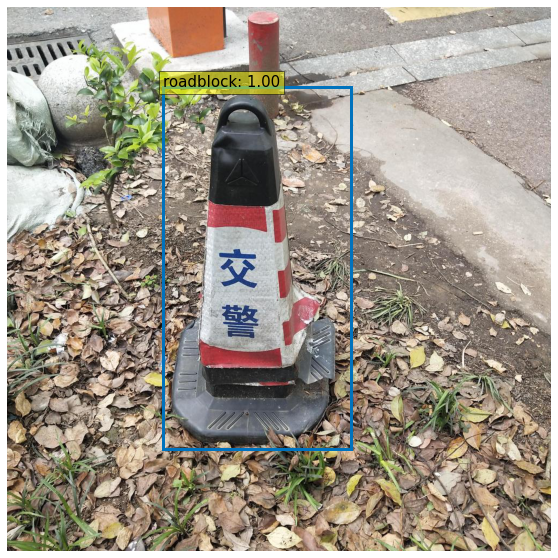

预测完成


In [30]:
# 部分图片可视化测试.
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/LZ122.jpg')
print("预测完成")

In [ ]:
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/LT49.jpg')
print("预测完成")

In [ ]:
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/hld011.jpg')
print("预测完成")

In [ ]:
print("开始预测")
img_predict(img_pth=r'MyDatasets/test/75.jpg')
print("预测完成")